# AMAZON PRODUCT REVIEWS – END-TO-END ANALYSIS
# Author: Linda Mthembu
#
# In this project, I analyse Amazon product reviews stored in a SQLite database.
# I clean the data, engineer new features, explore user & product behaviour, and
# perform basic sentiment analysis on review summaries.

# IMPORT LIBRARIES
# I imported these core libraries because they cover:
# - pandas / numpy: data manipulation
# - seaborn / matplotlib: visualisation
# - sqlite3: database access
# - TextBlob: sentiment analysis
# - Counter: keyword frequency


In [11]:
%pip install textblob


  Using cached textblob-0.19.0-py3-none-any.whl.metadata (4.4 kB)
  Using cached nltk-3.9.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
Using cached textblob-0.19.0-py3-none-any.whl (624 kB)
Using cached nltk-3.9.2-py3-none-any.whl (1.5 MB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)

   ---------------------------------------- 0/5 [tqdm]
   ---------------------------------------- 0/5 [tqdm]
   ---------------------------------------- 0/5 [tqdm]
   ---------------------------------------- 0/5 [tqdm]
   ---------------------------------------- 0/5 [tqdm]
   ---------------------------------------- 0/5 [tqdm]
   -------- ------------------------------- 1/5 [regex]
   -------- ------------------------------- 1/5 [regex]
   -------- ------------------------------- 1/5 [regex]
   ---------------- ----------------------- 2/5 [joblib]
   ---------------- ----------------------- 2/5 [joblib]
   ---------------- --------------------

In [12]:
import warnings
from warnings import filterwarnings
import sqlite3
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from textblob import TextBlob   

filterwarnings("ignore")

# DATASET CONTEXT (COLUMNS / FEATURES)
# =============================================================================
# I documented the key columns so that anyone reading this code understands:
# - what each field represents
# - how I intend to use it in the analysis
#
# Id                    -> unique review identifier
# ProductId             -> unique identifier for the product
# UserId                -> unique identifier for the user
# ProfileName           -> user display name
# HelpfulnessNumerator  -> number of users who found the review helpful
# HelpfulnessDenominator-> number of users who evaluated helpfulness
# Score                 -> rating between 1 and 5
# Time                  -> UNIX timestamp for the review
# Summary               -> short summary/title of the review
# Text                  -> full text of the review

# LOAD DATA FROM SQLITE DATABASE
# =============================================================================
# I used SQLite because the Amazon dataset is large and structured, and
# storing it in a database allows efficient querying and reproducibility.
# The table name is "REVIEWS" inside "database.sqlite".

In [13]:
# Create SQL connection
con = sqlite3.connect(r"C:\Users\LindaMthembu\OneDrive - iqbusiness (Pty) Ltd\Documents\Data Analysis Projects\Amazon\data\database.sqlite")

In [14]:
# Read entire REVIEWS table into a pandas DataFrame
df = pd.read_sql_query("SELECT * FROM REVIEWS", con)
print("Raw df shape (rows, columns):", df.shape)
print("df type:", type(df))


Raw df shape (rows, columns): (568454, 10)
df type: <class 'pandas.core.frame.DataFrame'>


# DATA PREPARATION / CLEANING
# In this step, I:
# - removed logically invalid rows
# - removed duplicate reviews
# - converted the Time column from UNIX seconds to datetime
# These steps are necessary to ensure that my downstream analysis is reliable.
# 

In [15]:
print("\nData preview:")
print(df.head(4))
print("\nColumns:", df.columns.tolist())


Data preview:
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection th

# Remove logically invalid rows based on Helpfulness
# HelpfulnessDenominator:
#   = (number of people who found the review useful)
#     + (number of people who did not find it useful)
# HelpfulnessNumerator:
#   = number of people who found the review helpful
#
# I did this check because HelpfulnessNumerator should never be greater than
# HelpfulnessDenominator. If it is, the row is logically invalid.

In [16]:
invalid_mask = df["HelpfulnessNumerator"] > df["HelpfulnessDenominator"]
invalid_rows = df[invalid_mask]
print("\nNumber of invalid rows (numerator > denominator):", invalid_rows.shape[0])

df_valid = df[~invalid_mask].copy()
print("Shape after removing invalid rows:", df_valid.shape)


Number of invalid rows (numerator > denominator): 2
Shape after removing invalid rows: (568452, 10)



# 4.2 Remove duplicate reviews
# I considered reviews duplicates if:
# - UserId, ProfileName, Time, and Text are exactly the same.
#
# I did this because it is highly unlikely that the same user posts the exact
# same text at the exact same timestamp multiple times for different products.
# Duplicates can bias the analysis, so I removed them.

In [17]:
dup_mask = df_valid.duplicated(subset=["UserId", "ProfileName", "Time", "Text"])
num_dups = dup_mask.sum()
print("Number of duplicate rows based on (UserId, ProfileName, Time, Text):", num_dups)

data = df_valid.drop_duplicates(subset=["UserId", "ProfileName", "Time", "Text"]).copy()
print("Shape after dropping duplicates:", data.shape)
print("\nData types after cleaning:")
print(data.dtypes)

Number of duplicate rows based on (UserId, ProfileName, Time, Text): 174521
Shape after dropping duplicates: (393931, 10)

Data types after cleaning:
Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object


# Convert Time from int (UNIX timestamp) to datetime
# -----------------------------------------------------------------------------
# The Time column is stored as UNIX seconds since 1970-01-01.
# I converted this to a pandas datetime because:
# - it is easier to work with dates (grouping by year, month, day, etc.)
# - it makes time-based analysis more intuitive.

In [18]:
print("\nFirst 5 raw Time values:", data["Time"].head().tolist())
data["Time"] = pd.to_datetime(data["Time"], unit="s")
print("Converted Time dtype:", data["Time"].dtype)


First 5 raw Time values: [1303862400, 1346976000, 1219017600, 1307923200, 1350777600]
Converted Time dtype: datetime64[ns]


# 
# USER-LEVEL ANALYSIS – WHO SHOULD AMAZON RECOMMEND MORE PRODUCTS TO?
# 
# Business question:
#   "To which users can Amazon recommend more products?"
#
# I answered this by:
# - aggregating reviews at the UserId level
# - deriving:
#     - number of summaries written
#     - number of full review texts written
#     - average rating given
#     - number of products purchased (approximated by review count per product)


Cleaned data shape: (393931, 10)
Number of unique ProfileName values: 218418
Number of unique UserId values: 256059

User-level aggregated dataframe (head):
                Number_of_summaries  num_text  avg_score  \
UserId                                                     
AY12DBB0U420B                   329       329   4.659574   
A3OXHLG6DIBRW8                  278       278   4.546763   
A281NPSIMI1C2R                  259       259   4.787645   
A1YUL9PCJR3JTY                  214       214   4.621495   
A1Z54EM24Y40LL                  211       211   4.383886   

                No_of_prods_purchased  
UserId                                 
AY12DBB0U420B                     329  
A3OXHLG6DIBRW8                    278  
A281NPSIMI1C2R                    259  
A1YUL9PCJR3JTY                    214  
A1Z54EM24Y40LL                    211  


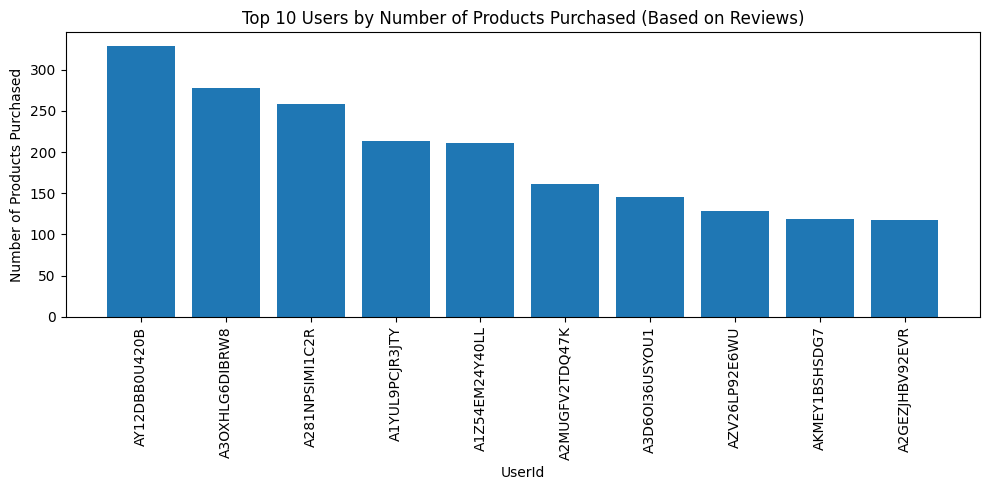

In [19]:
print("\nCleaned data shape:", data.shape)
print("Number of unique ProfileName values:", data["ProfileName"].nunique())
print("Number of unique UserId values:", data["UserId"].nunique())

# Group by UserId to create user-level features
user_agg = (
    data.groupby("UserId")
    .agg(
        {
            "Summary": "count",
            "Text": "count",
            "Score": "mean",
            "ProductId": "count",
        }
    )
)

# Rename for clarity
recommend_df = user_agg.sort_values(by="ProductId", ascending=False).copy()
recommend_df.columns = [
    "Number_of_summaries",
    "num_text",
    "avg_score",
    "No_of_prods_purchased",
]

print("\nUser-level aggregated dataframe (head):")
print(recommend_df.head())

# Plot top 10 users by number of products purchased
top_n = 10
top_users = recommend_df.head(top_n)

plt.figure(figsize=(10, 5))
plt.bar(top_users.index, top_users["No_of_prods_purchased"].values)
plt.xticks(rotation="vertical")
plt.title("Top 10 Users by Number of Products Purchased (Based on Reviews)")
plt.ylabel("Number of Products Purchased")
plt.xlabel("UserId")
plt.tight_layout()
plt.show()

# I created this chart because it visually highlights the most engaged customers,
# who are strong candidates for targeted recommendations and loyalty campaigns.

# PRODUCT-LEVEL ANALYSIS – WHICH PRODUCTS HAVE MANY REVIEWS?
# =============================================================================
# Business question:
#   "Which products have a good number of reviews and are most frequently bought?"
#
# I used ProductId value counts to:
# - understand product popularity
# - isolate high-volume products (threshold: > 500 reviews)
#   so I can study their rating distribution in more detail.
# =============================================================================


Number of unique products: 67624

Product counts (head):
            ProductId
ProductId            
B007JFMH8M        912
B002QWP89S        630
B003B3OOPA        622
B001EO5Q64        566
B0013NUGDE        558
Number of products with > 500 reviews: 11
Shape of frequent-products dataframe: (6504, 10)


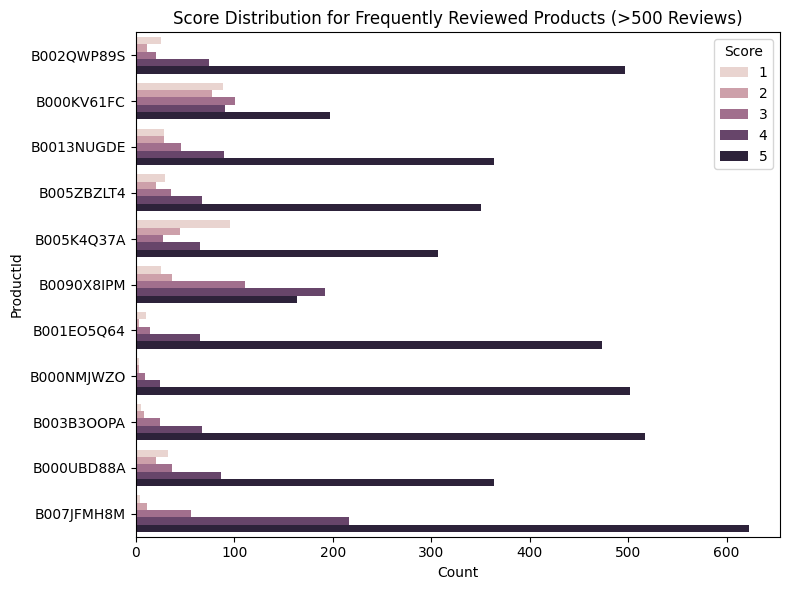

In [20]:
num_unique_products = data["ProductId"].nunique()
print("\nNumber of unique products:", num_unique_products)

# Count number of reviews per product
prod_count = data["ProductId"].value_counts().to_frame(name="ProductId")
print("\nProduct counts (head):")
print(prod_count.head())

# Filter products with more than 500 reviews
# I chose 500 as a threshold based on data behaviour;
# in practice, this would be informed by domain knowledge.
freq_prod_ids = prod_count[prod_count["ProductId"] > 500].index
print("Number of products with > 500 reviews:", len(freq_prod_ids))

# Filter dataset to only the most frequently reviewed products
fre_prod_df = data[data["ProductId"].isin(freq_prod_ids)].copy()
print("Shape of frequent-products dataframe:", fre_prod_df.shape)

# Plot distribution of scores for these frequent products
plt.figure(figsize=(8, 6))
sns.countplot(y="ProductId", data=fre_prod_df, hue="Score")
plt.title("Score Distribution for Frequently Reviewed Products (>500 Reviews)")
plt.xlabel("Count")
plt.ylabel("ProductId")
plt.legend(title="Score")
plt.tight_layout()
plt.show()

# I created this plot because it shows how customer ratings are distributed
# across the most popular products, helping identify consistently high or low
# rated items.

# FREQUENT VS NON-FREQUENT VIEWERS – RATING BEHAVIOUR
# Business question:
#   "Is there a difference between the behaviour of frequent and non-frequent reviewers?"
#
# I defined:
# - Frequent viewers: users who reviewed more than 50 products
# - Not Frequent viewers: users who reviewed 50 or fewer products
#
# Then I compared their rating distributions to see if heavy users behave
# differently from casual users.


Example user AY12DBB0U420B has 329 reviews.
Viewer type categories: ['Not Frequent' 'Frequent']

Frequent reviewers - score distribution (%):
Score
1     3.729429
2     3.932464
3     9.585381
4    21.147681
5    61.605044
Name: proportion, dtype: float64

Non-frequent reviewers - score distribution (%):
Score
1     9.349850
2     5.313426
3     7.507547
4    14.071191
5    63.757986
Name: proportion, dtype: float64


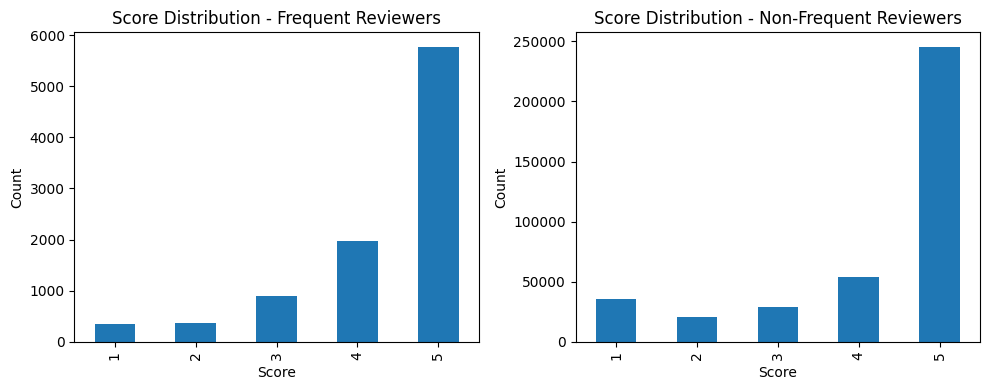

In [21]:
# Count number of reviews per user
user_review_counts = data["UserId"].value_counts()

# Example: check one heavy user
example_user = user_review_counts.index[0]
print(f"\nExample user {example_user} has {user_review_counts[example_user]} reviews.")

# Create viewer_type column
def label_viewer_type(user_id: str) -> str:
    # I used > 50 as my threshold because I wanted to focus on very active users.
    # This value can be tuned based on business requirements.
    return "Frequent" if user_review_counts[user_id] > 50 else "Not Frequent"


data["viewer_type"] = data["UserId"].apply(label_viewer_type)
print("Viewer type categories:", data["viewer_type"].unique())

# Split into frequent and non-frequent groups
freq_df = data[data["viewer_type"] == "Frequent"].copy()
not_freq_df = data[data["viewer_type"] == "Not Frequent"].copy()

# Compute rating distribution in % for each group
freq_score_pct = freq_df["Score"].value_counts(normalize=True) * 100
not_freq_score_pct = not_freq_df["Score"].value_counts(normalize=True) * 100

print("\nFrequent reviewers - score distribution (%):")
print(freq_score_pct.sort_index())
print("\nNon-frequent reviewers - score distribution (%):")
print(not_freq_score_pct.sort_index())

# Plot distributions
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
freq_df["Score"].value_counts().sort_index().plot(kind="bar")
plt.title("Score Distribution - Frequent Reviewers")
plt.xlabel("Score")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
not_freq_df["Score"].value_counts().sort_index().plot(kind="bar")
plt.title("Score Distribution - Non-Frequent Reviewers")
plt.xlabel("Score")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

# I created this comparison because it helps show whether frequent reviewers
# behave differently. In this dataset, frequent reviewers give fewer extreme
# 1-star and 5-star ratings, suggesting they might be more discerning.

# VERBOSITY ANALYSIS – ARE FREQUENT USERS MORE VERBOSE?
# 
# Business question:
#   "Do frequent users write longer, more detailed reviews?"
#
# I approximated verbosity by:
# - counting the number of words in each review Text
# - comparing word-count distributions between frequent and non-frequent users


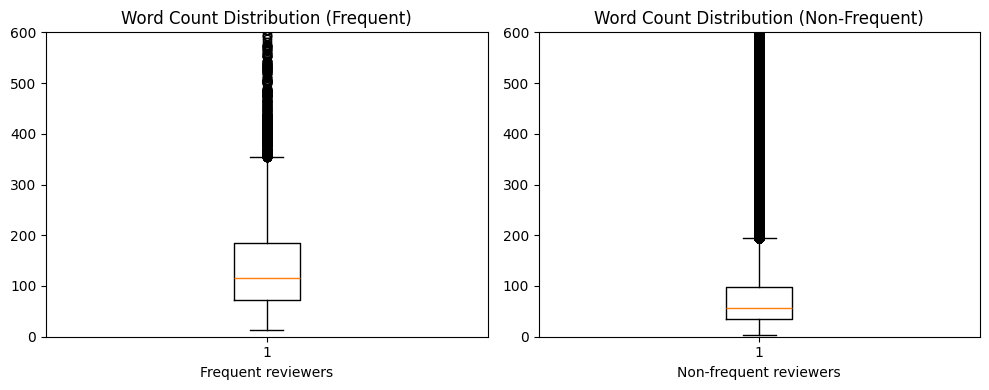

In [22]:
# Compute text length in words
def calculate_length(text: str) -> int:
    # I split the review text by spaces and count tokens to derive word counts.
    return len(str(text).split(" "))


data["Text_length"] = data["Text"].apply(calculate_length)

# Split again based on viewer_type
not_freq_data = data[data["viewer_type"] == "Not Frequent"].copy()
freq_data = data[data["viewer_type"] == "Frequent"].copy()

# Create boxplots for word count distributions
fig = plt.figure(figsize=(10, 4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.boxplot(freq_data["Text_length"])
ax1.set_xlabel("Frequent reviewers")
ax1.set_title("Word Count Distribution (Frequent)")
ax1.set_ylim(0, 600)

ax2 = fig.add_subplot(1, 2, 2)
ax2.boxplot(not_freq_data["Text_length"])
ax2.set_xlabel("Non-frequent reviewers")
ax2.set_title("Word Count Distribution (Non-Frequent)")
ax2.set_ylim(0, 600)

plt.tight_layout()
plt.show()

# I used boxplots because they show the median, interquartile range, and
# spread of word counts. This makes it easy to compare verbosity between groups.



# SENTIMENT ANALYSIS ON REVIEW SUMMARIES
# Business question:
#   "What is the overall sentiment of review summaries, and what keywords
#    are associated with positive vs negative sentiment?"
#
# I used TextBlob for a quick polarity score:
#   polarity < 0  -> negative sentiment
#   polarity > 0  -> positive sentiment
#   polarity == 0 -> neutral sentiment
#
# Since the dataset is large, I sampled 50,000 rows for performance reasons.

In [23]:
print("\nTotal cleaned rows before sentiment sampling:", data.shape[0])

# Take a sample of 50,000 reviews (or fewer if dataset is smaller)
sample_size = min(50_000, data.shape[0])
sample = data.iloc[:sample_size].copy()
print("Sample size used for sentiment analysis:", sample.shape[0])

# Compute polarity scores for Summary
polarity_scores = []
for text in sample["Summary"]:
    try:
        polarity_scores.append(TextBlob(str(text)).sentiment.polarity)
    except Exception:
        # I appended 0 if TextBlob failed, to keep list length consistent.
        polarity_scores.append(0)

sample["polarity"] = polarity_scores
print("\nSample with polarity (head):")
print(sample[["Summary", "polarity"]].head())

# Split into negative and positive
sample_negative = sample[sample["polarity"] < 0].copy()
sample_positive = sample[sample["polarity"] > 0].copy()

# Extract most common negative and positive summaries/phrases
top_negative = Counter(sample_negative["Summary"]).most_common(10)
top_positive = Counter(sample_positive["Summary"]).most_common(10)

print("\nTop 10 negative summaries (by frequency):")
for text, count in top_negative:
    print(f"{count:4d}  |  {text}")

print("\nTop 10 positive summaries (by frequency):")
for text, count in top_positive:
    print(f"{count:4d}  |  {text}")

# I performed this sentiment analysis because it helps me understand:
# - the main pain points customers complain about (negative keywords)
# - the main strengths customers praise (positive keywords)
# This can support product improvement, marketing messaging, and future
# recommendation models.


Total cleaned rows before sentiment sampling: 393931
Sample size used for sentiment analysis: 50000

Sample with polarity (head):
                 Summary  polarity
0  Good Quality Dog Food       0.7
1      Not as Advertised       0.0
2  "Delight" says it all       0.0
3         Cough Medicine       0.0
4            Great taffy       0.8

Top 10 negative summaries (by frequency):
  44  |  Disappointed
  32  |  Disappointing
  18  |  Bland
  17  |  Awful
  17  |  Not what I expected
  15  |  Terrible
  15  |  Horrible
  15  |  disappointed
  12  |  Disgusting
  11  |  not good

Top 10 positive summaries (by frequency):
 208  |  Delicious!
 204  |  Delicious
 100  |  Great product
  85  |  Excellent
  81  |  Love it!
  81  |  Great
  77  |  Great Product
  70  |  Great!
  51  |  Good stuff
  50  |  Awesome


In [25]:
%pip install scikit-learn


   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.9 MB 5.6 MB/s eta 0:00:02
   -------- ------------------------------- 1.8/8.9 MB 4.6 MB/s eta 0:00:02
   ------------ --------------------------- 2.9/8.9 MB 4.8 MB/s eta 0:00:02
   --------------- ------------------------ 3.4/8.9 MB 4.7 MB/s eta 0:00:02
   ----------------- ---------------------- 3.9/8.9 MB 4.1 MB/s eta 0:00:02
   ----------------- ---------------------- 3.9/8.9 MB 4.1 MB/s eta 0:00:02
   ----------------------- ---------------- 5.2/8.9 MB 3.5 MB/s eta 0:00:02
   ------------------------- -------------- 5.8/8.9 MB 3.7 MB/s eta 0:00:01
   ---------------------------- ----------- 6.3/8.9 MB 3.4 MB/s eta 0:00:01
   ------------------------------ --------- 6.8/8.9 MB 3.4 MB/s eta 0:00:01
   --------------------------------- ------ 7.3/8.9 MB 3.2 MB/s eta 0:00:01
   -------------------------------------- - 8.7/8.9 MB 3.6 MB/s eta 0:00:01
   ----------------

In [26]:
from collections import Counter
from textblob import TextBlob          # I use this for quick sentiment estimation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

sns.set(style="whitegrid")

# I created a helpfulness ratio because it normalises the helpfulness score
# and makes it easier to compare reviews with different denominators.
data = data.copy()
mask_den = data["HelpfulnessDenominator"] > 0
data.loc[mask_den, "helpfulness_ratio"] = (
    data.loc[mask_den, "HelpfulnessNumerator"] /
    data.loc[mask_den, "HelpfulnessDenominator"]
)
data["helpfulness_ratio"] = data["helpfulness_ratio"].fillna(0)

# I added a month-year column so that I can easily aggregate trends over time.
data["year_month"] = data["Time"].dt.to_period("M").astype(str)

# I recomputed the user-level aggregation used for CLV-type analysis.
user_agg = (
    data.groupby("UserId")
    .agg(
        Number_of_summaries=("Summary", "count"),
        num_text=("Text", "count"),
        avg_score=("Score", "mean"),
        No_of_prods_purchased=("ProductId", "count"),
    )
)
recommend_df = user_agg.sort_values("No_of_prods_purchased", ascending=False)

# For heavy NLP steps, I sample a subset to keep things responsive while
# still preserving patterns.
text_sample = data.sample(min(50_000, len(data)), random_state=42)



# PRODUCT "CATEGORIES" VIA TOPIC CLUSTERS + SENTIMENT
#    (Risk & Opportunity Analysis)
# ============================================================================

# I approximated product "categories" by clustering review summaries into topics.
# This gives the business a way to see which themes/products have high volume
# and high/low sentiment.


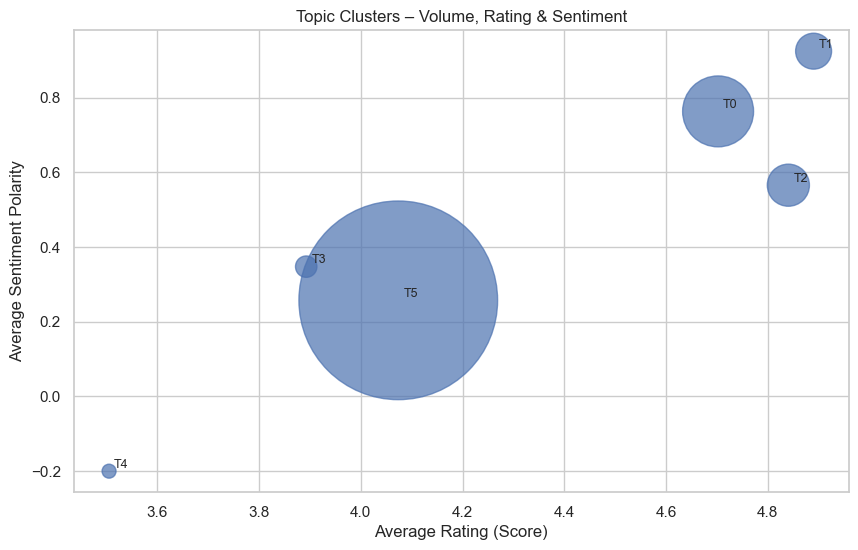

In [27]:
# --- 1.1 Vectorise summaries with TF-IDF ---
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words="english",
    min_df=5
)

# I used the sampled data to fit the model for speed.
summary_texts = text_sample["Summary"].fillna("").astype(str)
tfidf_matrix = tfidf.fit_transform(summary_texts)

# --- 1.2 Cluster into K topics (pseudo-categories) ---
K = 6  # I chose 6 clusters to keep it interpretable.
kmeans = KMeans(n_clusters=K, random_state=42, n_init="auto")
text_sample["topic_cluster"] = kmeans.fit_predict(tfidf_matrix)

# --- 1.3 Compute basic sentiment on summaries ---
def get_polarity(text: str) -> float:
    # I wrapped this in a try/except so that bad text does not break the loop.
    try:
        return TextBlob(str(text)).sentiment.polarity
    except Exception:
        return 0.0

text_sample["polarity"] = text_sample["Summary"].astype(str).apply(get_polarity)

# --- 1.4 Aggregate per topic: volume, avg score, avg polarity ---
topic_summary = (
    text_sample
    .groupby("topic_cluster")
    .agg(
        n_reviews=("Summary", "count"),
        avg_score=("Score", "mean"),
        avg_polarity=("polarity", "mean")
    )
    .reset_index()
)

# --- 1.5 Bubble plot: Topic risk/opportunity map ---
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    topic_summary["avg_score"],
    topic_summary["avg_polarity"],
    s=topic_summary["n_reviews"] * 0.5,  # I scaled bubble sizes for readability.
    alpha=0.7
)
for _, row in topic_summary.iterrows():
    plt.text(row["avg_score"] + 0.01, row["avg_polarity"] + 0.01,
             f"T{int(row['topic_cluster'])}", fontsize=9)

plt.title("Topic Clusters – Volume, Rating & Sentiment")
plt.xlabel("Average Rating (Score)")
plt.ylabel("Average Sentiment Polarity")
plt.grid(True)
plt.show()

# Business interpretation (for your presentation):
# - I can treat each cluster T0–T5 as a pseudo-category.
# - High score + high polarity + large bubble = strong opportunity to promote.
# - Low score + negative polarity + large bubble = risk area needing attention.

# CUSTOMER LIFETIME VALUE (CLV) STYLE SEGMENTS

# I segmented users based on how many products they purchased and their
# average score, so the business can identify high-value / high-risk groups.

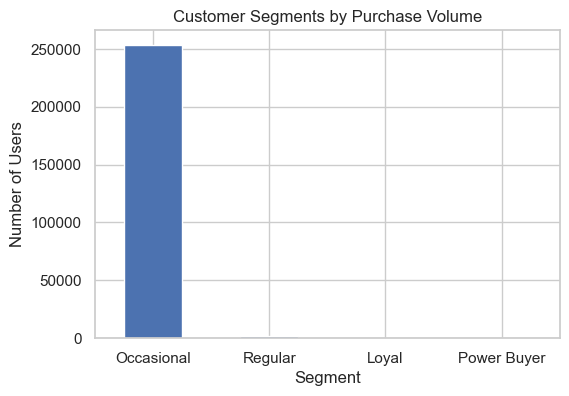

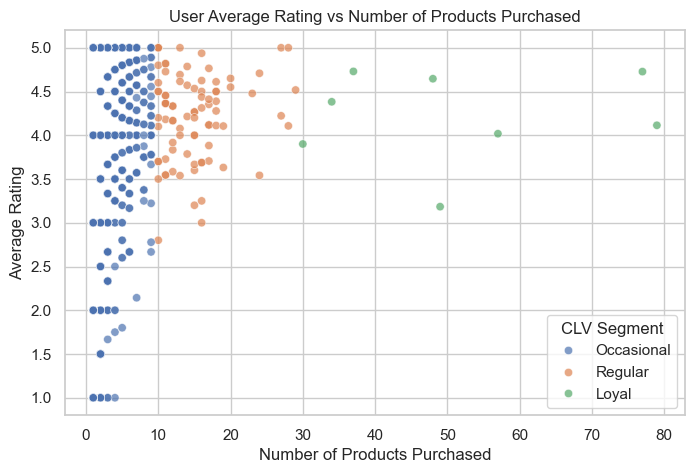

In [28]:
# --- 2.1 Create simple CLV buckets ---
def clv_segment(row):
    if row["No_of_prods_purchased"] >= 100:
        return "Power Buyer"
    if row["No_of_prods_purchased"] >= 30:
        return "Loyal"
    if row["No_of_prods_purchased"] >= 10:
        return "Regular"
    return "Occasional"

recommend_df["clv_segment"] = recommend_df.apply(clv_segment, axis=1)

# --- 2.2 Bar chart: number of users in each CLV segment ---
plt.figure(figsize=(6, 4))
recommend_df["clv_segment"].value_counts().plot(kind="bar")
plt.title("Customer Segments by Purchase Volume")
plt.xlabel("Segment")
plt.ylabel("Number of Users")
plt.xticks(rotation=0)
plt.show()

# --- 2.3 Scatter: avg score vs number of products purchased ---
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=recommend_df.sample(min(10_000, len(recommend_df)), random_state=42),
    x="No_of_prods_purchased",
    y="avg_score",
    hue="clv_segment",
    alpha=0.7
)
plt.title("User Average Rating vs Number of Products Purchased")
plt.xlabel("Number of Products Purchased")
plt.ylabel("Average Rating")
plt.legend(title="CLV Segment")
plt.show()

# In the presentation I can say:
# - Power Buyers and Loyal customers are key targets for cross-sell and loyalty.
# - If I see Power Buyers with low average scores, that’s a churn risk signal.

# HELPFULNESS VS SCORE – DOES IT MATTER?

# I analysed whether more helpful reviews tend to give higher or lower scores.
# This helps the business understand if highly visible reviews are biased.

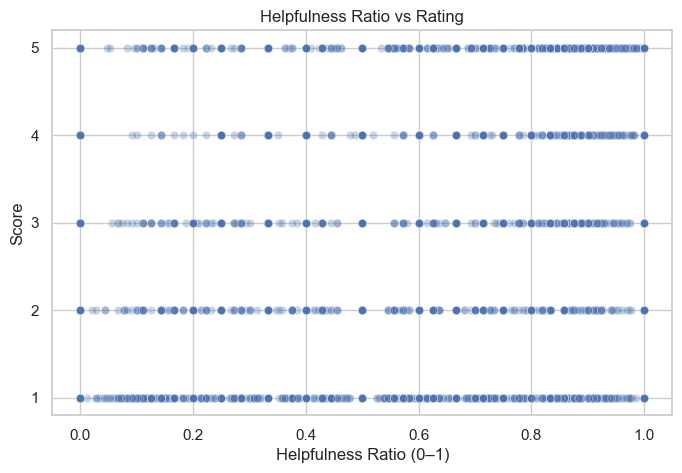

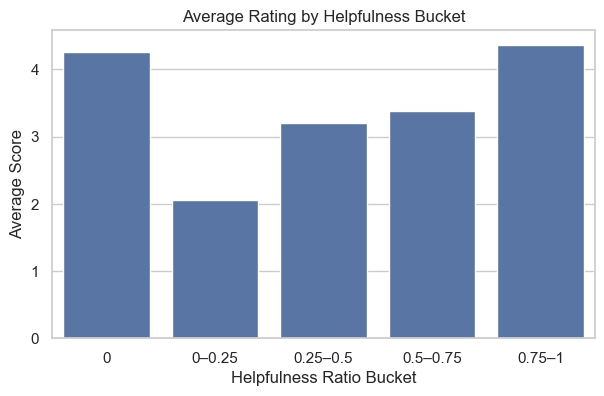

In [29]:
# I analysed whether more helpful reviews tend to give higher or lower scores.
# This helps the business understand if highly visible reviews are biased.

plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=data.sample(min(50_000, len(data)), random_state=42),
    x="helpfulness_ratio",
    y="Score",
    alpha=0.3
)
plt.title("Helpfulness Ratio vs Rating")
plt.xlabel("Helpfulness Ratio (0–1)")
plt.ylabel("Score")
plt.yticks([1, 2, 3, 4, 5])
plt.show()

# I can also show average score by helpfulness bucket.
data["helpfulness_bucket"] = pd.cut(
    data["helpfulness_ratio"],
    bins=[-0.01, 0, 0.25, 0.5, 0.75, 1.0],
    labels=["0", "0–0.25", "0.25–0.5", "0.5–0.75", "0.75–1"]
)

plt.figure(figsize=(7, 4))
sns.barplot(
    data=data,
    x="helpfulness_bucket",
    y="Score",
    estimator=np.mean,
    ci=None
)
plt.title("Average Rating by Helpfulness Bucket")
plt.xlabel("Helpfulness Ratio Bucket")
plt.ylabel("Average Score")
plt.show()

# For the business:
# - If top helpfulness buckets show balanced ratings, reviews are credible.
# - If highly helpful reviews are mostly 5-star, there might be bias.

# SIMPLE FRAUD / SUSPICIOUS REVIEW SIGNALS

# I defined "suspicious" reviews as:
# - extremely short text
# - extreme scores (1 or 5)
# - zero helpfulness votes
# This is not a full fraud model, but it gives the business a starting point.

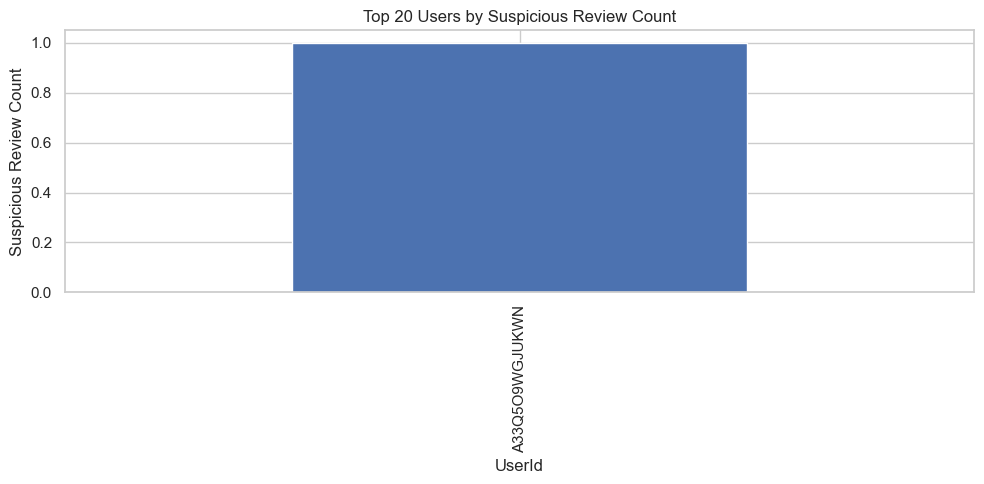

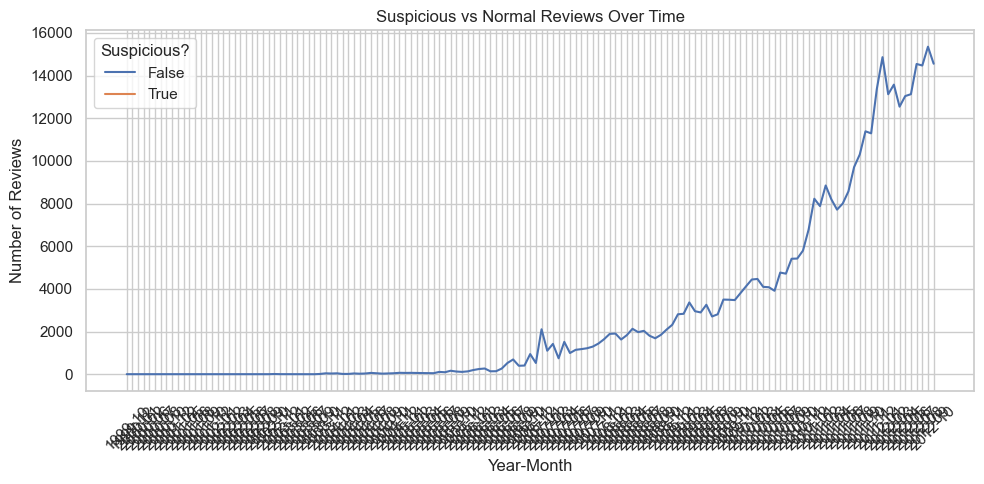

In [30]:
# I defined "suspicious" reviews as:
# - extremely short text
# - extreme scores (1 or 5)
# - zero helpfulness votes
# This is not a full fraud model, but it gives the business a starting point.

suspicious_mask = (
    (data["Text_length"] <= 5) &
    (data["Score"].isin([1, 5])) &
    (data["HelpfulnessDenominator"] == 0)
)
data["is_suspicious"] = suspicious_mask

# --- 4.1 Count suspicious reviews per user (top 20) ---
suspicious_users = (
    data[data["is_suspicious"]]
    .groupby("UserId")
    .size()
    .sort_values(ascending=False)
    .head(20)
)

plt.figure(figsize=(10, 5))
suspicious_users.plot(kind="bar")
plt.title("Top 20 Users by Suspicious Review Count")
plt.ylabel("Suspicious Review Count")
plt.xlabel("UserId")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# --- 4.2 Time trend of suspicious vs normal reviews ---
monthly_suspicious = (
    data
    .groupby(["year_month", "is_suspicious"])
    .size()
    .reset_index(name="count")
)

plt.figure(figsize=(10, 5))
sns.lineplot(
    data=monthly_suspicious,
    x="year_month",
    y="count",
    hue="is_suspicious"
)
plt.xticks(rotation=45)
plt.title("Suspicious vs Normal Reviews Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Number of Reviews")
plt.legend(title="Suspicious?")
plt.tight_layout()
plt.show()

# I can use this to say:
# - If suspicious activity spikes in a month, we may have review manipulation.

# PRODUCT QUALITY OVER TIME – RATING TREND

# I analysed how average rating changes over time globally and for a top product.
# This helps detect quality deterioration or improvements.

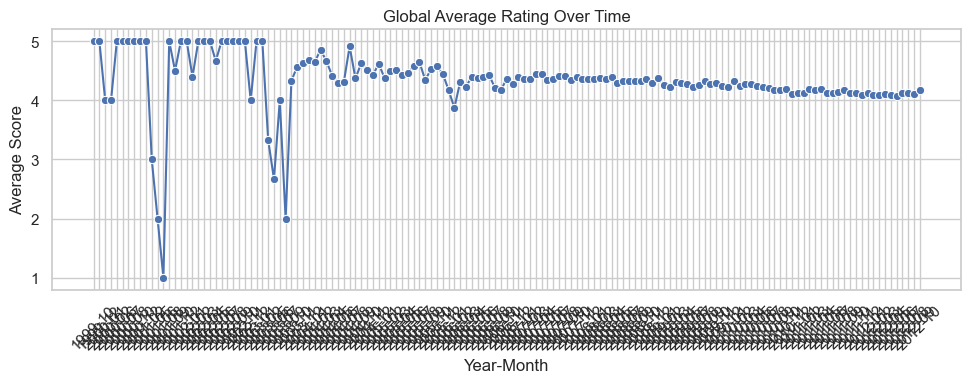

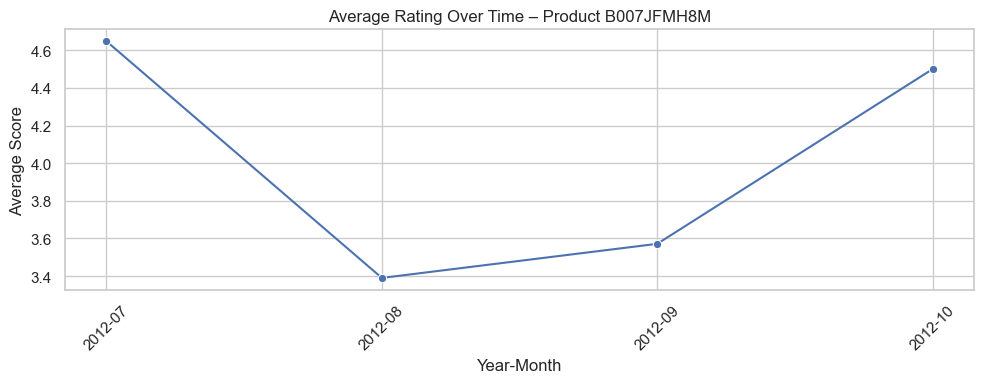

In [31]:
# I analysed how average rating changes over time globally and for a top product.
# This helps detect quality deterioration or improvements.

# --- 5.1 Global trend ---
monthly_score = (
    data.groupby("year_month")["Score"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 4))
sns.lineplot(data=monthly_score, x="year_month", y="Score", marker="o")
plt.xticks(rotation=45)
plt.title("Global Average Rating Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Average Score")
plt.tight_layout()
plt.show()

# --- 5.2 Trend for one top product ---
top_product = (
    data["ProductId"]
    .value_counts()
    .idxmax()
)
top_prod_monthly = (
    data[data["ProductId"] == top_product]
    .groupby("year_month")["Score"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 4))
sns.lineplot(data=top_prod_monthly, x="year_month", y="Score", marker="o")
plt.xticks(rotation=45)
plt.title(f"Average Rating Over Time – Product {top_product}")
plt.xlabel("Year-Month")
plt.ylabel("Average Score")
plt.tight_layout()
plt.show()

# Business message:
# - Sudden drops for a product can indicate quality issues or supplier changes.

#  EMOTION-STYLE BUCKETS FROM SENTIMENT

# I simplified emotions into:
# - Joy (polarity >= 0.4)
# - Neutral (-0.4 < polarity < 0.4)
# - Anger/Sad (polarity <= -0.4)
# This isn't full emotion analysis, but it gives a directional view.

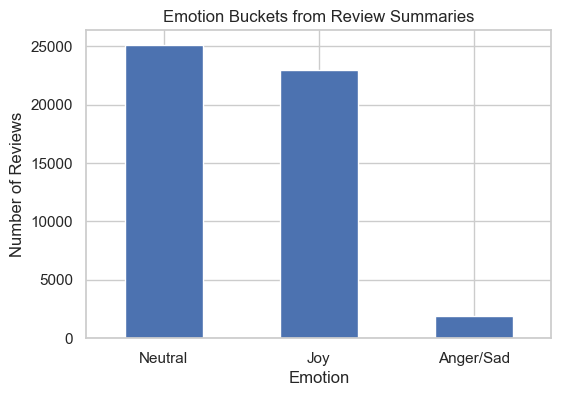

In [32]:
# I simplified emotions into:
# - Joy (polarity >= 0.4)
# - Neutral (-0.4 < polarity < 0.4)
# - Anger/Sad (polarity <= -0.4)
# This isn't full emotion analysis, but it gives a directional view.

text_sample["polarity"] = text_sample["Summary"].astype(str).apply(get_polarity)

def map_emotion(p):
    if p >= 0.4:
        return "Joy"
    if p <= -0.4:
        return "Anger/Sad"
    return "Neutral"

text_sample["emotion"] = text_sample["polarity"].apply(map_emotion)

plt.figure(figsize=(6, 4))
text_sample["emotion"].value_counts().plot(kind="bar")
plt.title("Emotion Buckets from Review Summaries")
plt.xlabel("Emotion")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)
plt.show()

# I can then drill down by product category/cluster if needed to see:
# - which topics are joy-driven vs anger-driven.


# REVIEWER BEHAVIOUR PROFILING – LENGTH vs HELPFULNESS

# I combined text length, helpfulness, and viewer_type to profile reviewers.



# For the business:
# - If long reviews from frequent users are more helpful, we can highlight those
#   higher on the product page.

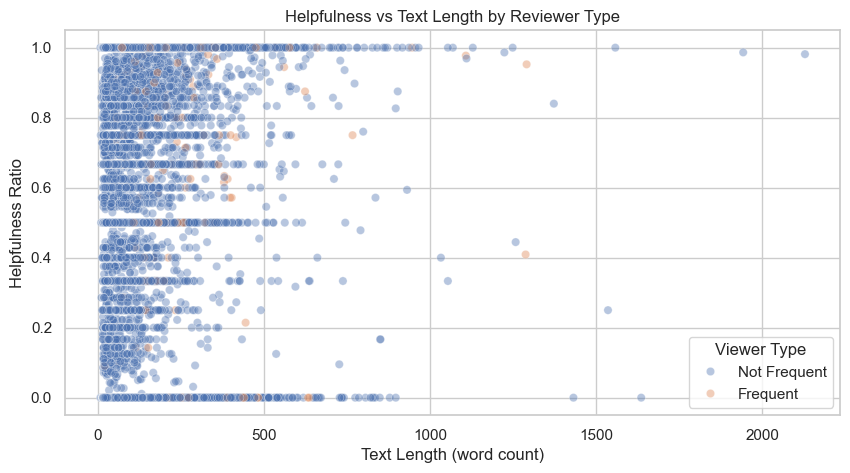

In [33]:
plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=data.sample(min(50_000, len(data)), random_state=42),
    x="Text_length",
    y="helpfulness_ratio",
    hue="viewer_type",
    alpha=0.4
)
plt.title("Helpfulness vs Text Length by Reviewer Type")
plt.xlabel("Text Length (word count)")
plt.ylabel("Helpfulness Ratio")
plt.legend(title="Viewer Type")
plt.show()

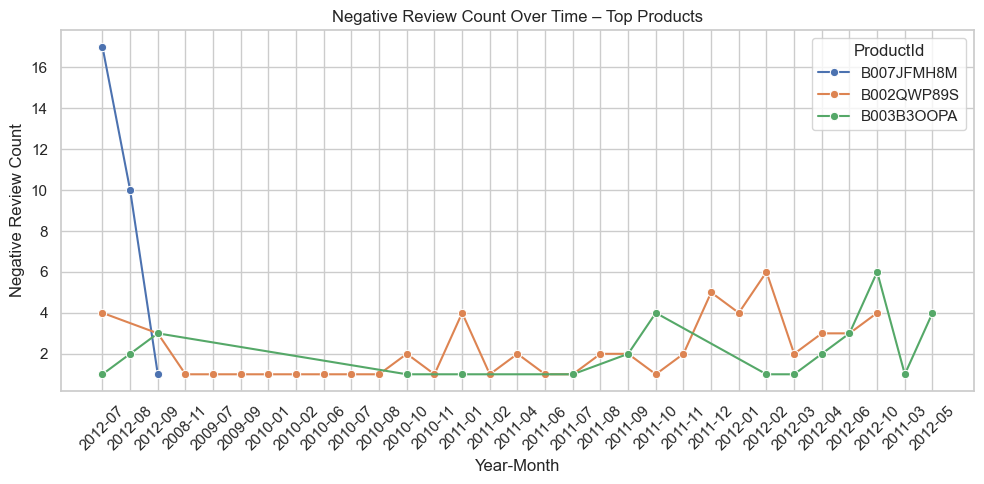

In [ ]:
# PRODUCT FAILURE / DEFECT SIGNALS – NEGATIVE REVIEWS OVER TIME

# I focused on 1–2 top-selling products and counted negative sentiment reviews
# over time to detect defect spikes.

# --- 8.1 Define negative review (score <= 2 or polarity < 0) ---
data["summary_polarity"] = data["Summary"].astype(str).apply(get_polarity)
data["is_negative"] = (data["Score"] <= 2) | (data["summary_polarity"] < 0)

top_products = data["ProductId"].value_counts().head(3).index.tolist()

plt.figure(figsize=(10, 5))
for pid in top_products:
    tmp = (
        data[(data["ProductId"] == pid) & (data["is_negative"])]
        .groupby("year_month")
        .size()
        .reset_index(name="neg_count")
    )
    sns.lineplot(data=tmp, x="year_month", y="neg_count", marker="o", label=str(pid))

plt.xticks(rotation=45)
plt.title("Negative Review Count Over Time – Top Products")
plt.xlabel("Year-Month")
plt.ylabel("Negative Review Count")
plt.legend(title="ProductId")
plt.tight_layout()
plt.show()

# This gives the business a clear signal of when specific products start to fail.

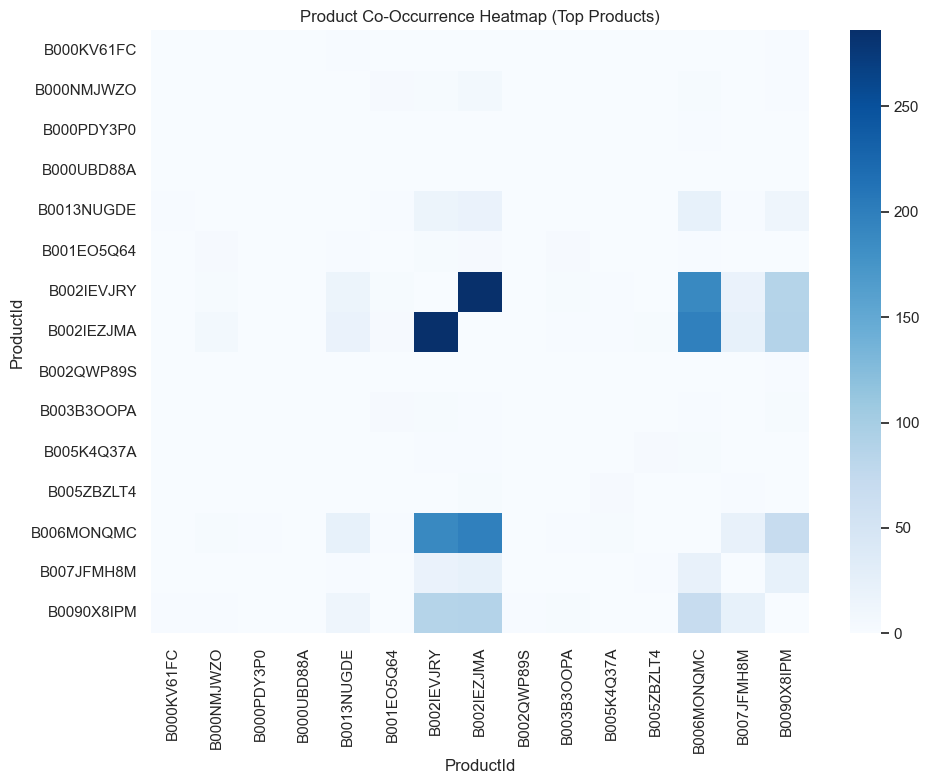

In [35]:

# CROSS-PRODUCT CO-PURCHASE INSIGHTS

# I approximated "users who reviewed X also reviewed Y" by counting product
# co-occurrences per user. I then visualised a heatmap for the most frequent
# products to inspire cross-sell strategies.

# --- 9.1 Build a small user–product matrix for top N products ---
N = 15
top_prod_ids = data["ProductId"].value_counts().head(N).index

# I restricted to users who interacted with at least one of these top N products.
subset = data[data["ProductId"].isin(top_prod_ids)][["UserId", "ProductId"]].drop_duplicates()

# Create user-product pivot
user_prod_matrix = pd.crosstab(subset["UserId"], subset["ProductId"])

# Compute co-occurrence matrix: products that appear together across users
co_occurrence = user_prod_matrix.T.dot(user_prod_matrix)
np.fill_diagonal(co_occurrence.values, 0)  # I set diagonal to 0 for clarity.

plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence, cmap="Blues")
plt.title("Product Co-Occurrence Heatmap (Top Products)")
plt.xlabel("ProductId")
plt.ylabel("ProductId")
plt.tight_layout()
plt.show()

# Business angle:
# - Darker cells show product pairs that users often buy together,
#   which is a direct input to "Frequently Bought Together" suggestions.

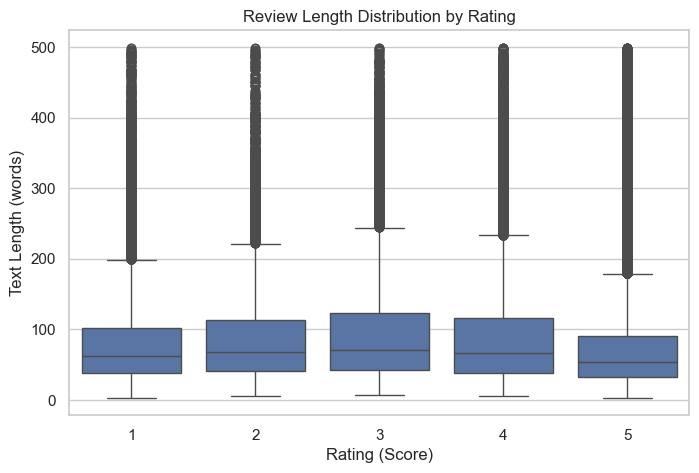

In [36]:
 
# TEXT LENGTH VS RATING – DO LONG REVIEWS DIFFER FROM SHORT ONES?
# ============================================================================

# I visualised how review length varies across rating categories to show
# whether positive/negative reviews tend to be longer.

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=data[data["Text_length"] < 500],  # I capped at 500 words to remove extreme outliers.
    x="Score",
    y="Text_length"
)
plt.title("Review Length Distribution by Rating")
plt.xlabel("Rating (Score)")
plt.ylabel("Text Length (words)")
plt.show()

# I can tell the business:
# - If negative reviews are much longer, customers might be detailing problems.
# - If short 5-star reviews dominate, some may be shallow or incentivised.

In [37]:
# I saved the cleaned dataset so that my Streamlit app can load it directly
# without needing SQLite on the server.
from pathlib import Path

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

clean_path = DATA_DIR / "amazon_reviews_clean.csv"
data.to_csv(clean_path, index=False)
print(f"✅ Saved cleaned data to: {clean_path.resolve()}")


✅ Saved cleaned data to: C:\Users\LindaMthembu\OneDrive - iqbusiness (Pty) Ltd\Documents\Data Analysis Projects\Amazon\notebook\data\amazon_reviews_clean.csv
